In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm, binned_statistic, gausshyper, invgauss
import math
import pandas as pd
import time
from functions import *

print(tf.__version__)


2.5.0


In [2]:
start = time.time()

In [3]:
class HParams(object):
    def __init__(self):
        self.nEpochs = 10
        self.nUpdates_Adversary = 10
        self.nUpdates_Classifier = 10
        self.nodes = 32
        self.batch_size = 256 #512
        self.adversary_lr = 1.0
        self.classifier_lr = 0.1
        self.valSplit = 0.9
        self.xBins = 4
        self.Lambda = 1250

# class HPARAMSEncoder(json.JSONEncoder):
#         def default(self, o):
#             return o.__dict__     

HPARAMS = HParams()

In [4]:
np.random.seed(938471893)

In [5]:
def normalize01(x):
    norm = (x - np.min(x)) / (np.max(x) - np.min(x))
    return norm

In [6]:
nEvents = 10000

x1 = norm.rvs(size=nEvents)
x2 = np.exp(np.random.rand(nEvents))

z1 = 0.5*np.random.rand(nEvents)
z2 = 1-0.5*np.random.rand(nEvents)



x1 = np.random.normal(loc=0.1, scale=0.02, size=nEvents)
x2 = np.random.exponential(scale=0.02, size=nEvents)

# z1 = np.random.exponential(scale=0.18, size=nEvents)
# z2 = np.random.exponential(scale=0.06, size=nEvents)

z1 = 1-np.random.normal(loc = 0.01, scale=0.1, size=nEvents)
z2 = 1-np.random.normal(loc = 0.2, scale=0.1, size=nEvents)

# z1 = np.random.normal(loc=0.5, scale=0.02, size=nEvents) 
# z1 = np.random.normal(loc=0.5, scale=0.09, size=nEvents) #signal_z_littleoverlap

# # z2 = np.random.exponential(loc=0.5, scale=0.09, size=nEvents) 
# z1 = np.random.exponential(scale=0.1, size=nEvents)
# z2 = np.random.exponential(scale=0.1, size=nEvents) 

# # masking z to ensure z<1.0
# z1 = np.where(z1<1.0, z1, z1%1) #signal_z   
# # making so that z is always more than 1-z
# z2 = np.where(z2>0.5, z2, (1-z2))



# x1_norm = (x1-np.min(x1))/(np.max(x1)-np.min(x))
# x2_norm = (b - np.min(b))/(np.max(b)-np.min(b))


# z1_norm = (z1-np.min(s))/(np.max(z1)-np.min(z1))
# z2_norm = (z2 - np.min(z2))/(np.max(z2)-np.min(z2))



feat1 = normalize01(np.append(x1, x2))
feat2 = normalize01(np.append(z1, z2))
feat2 = np.append(z1, z2)

labels1 = np.append(np.ones_like(x1), np.zeros_like(x2))

idx = np.arange(len(feat1))

np.random.shuffle(idx)

feat1 = feat1[idx]
feat2 = feat2[idx]
labels1 = labels1[idx]

feats = {'x': feat1,
         'z': feat2,
        }
labels = ['x', 'z']


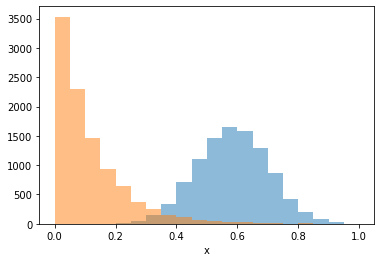

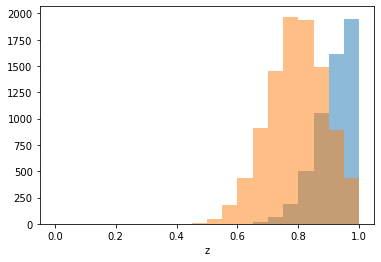

In [7]:
brange = np.linspace(0,1,21)
plt.xlabel('x')
plt.hist(feat1[labels1==1], alpha=0.5, bins=brange)
plt.hist(feat1[labels1==0], alpha=0.5, bins=brange)
plt.show()
plt.xlabel('z')
plt.hist(feat2[labels1==1], alpha=0.5, bins=brange)
plt.hist(feat2[labels1==0], alpha=0.5, bins=brange)
plt.show()

In [8]:
x = feats['x']
z = feats['z']

In [9]:
xbins = [0, 0.25, 0.5, 0.75, 1.0]
# xbins = [0, 1/3, 2/3, 1.0]
bin_x = np.digitize(x, xbins) - 1
bin_labels = tf.one_hot(bin_x, HPARAMS.xBins)

2022-02-15 09:58:18.832977: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(array([8913., 3339., 6991.,  757.]),
 array([0., 1., 2., 3., 4.]),
 <BarContainer object of 4 artists>)

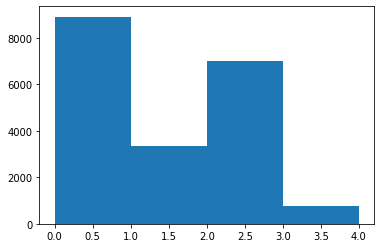

In [10]:
plt.hist(bin_x, bins=HPARAMS.xBins)

In [11]:
print(bin_labels.shape)
print(bin_x.shape)

(20000, 4)
(20000,)


In [12]:
y = labels1

In [13]:
feats['x'].shape

(20000,)

In [14]:
# https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

# Instantiate an optimizer.
optimizer_adv = tf.keras.optimizers.SGD(learning_rate=HPARAMS.adversary_lr)
optimizer_class = tf.keras.optimizers.SGD(learning_rate=HPARAMS.classifier_lr)

# Instantiate a loss function.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Reserve 10,000 samples for validation.
# x_val = x_train[-10000:]
# y_val = y_train[-10000:]
x_train = {key: feats[key].reshape(len(feats[key]), 1) for key in feats.keys()}
y_train = labels

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((feats, y)).batch(HPARAMS.batch_size)

# Prepare the validation dataset.
# val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# val_dataset = val_dataset.batch(batch_size)



In [15]:
train_dataset_adv = tf.data.Dataset.from_tensor_slices((bin_x, bin_labels)).batch(HPARAMS.batch_size)


In [16]:
def advLoss(y_true, y_pred):
    
    loss = tf.reduce_mean(tf.multiply(y_true, tf.math.log(y_pred)))
    return tf.abs(loss)


def classifierLoss(y_true, y_pred):
    
    loss = -1*tf.reduce_mean(tf.multiply(y_true, tf.math.log(y_pred)))
    return loss
    
    

In [17]:
# advLoss(tf.constant([0,1], dtype=float), tf.constant([[0.25, 0.75], [0.25, 0.75]], dtype=float))

In [18]:
def getClassifier(name):
    
    inputs = [tf.keras.Input(shape=(1,), name="x"),
              tf.keras.Input(shape=(1,), name="z"),
             ]

    x3 = tf.keras.layers.concatenate(inputs=inputs, axis=-1)


    x4 = tf.keras.layers.Dense(HPARAMS.nodes, activation="relu")(x3)
    x5 = tf.keras.layers.Dense(HPARAMS.nodes, activation="relu")(x4)

    outputs = tf.keras.layers.Dense(2, name="predictions")(x5)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

    return model



def getAdversary(name):
    
    inputs =[tf.keras.Input(shape=(2,), name="classifier_output"),
             tf.keras.Input(shape=(1,), name="binned_x"),
             ]

    
    x = tf.keras.layers.concatenate(inputs=inputs, axis=-1)


    x = tf.keras.layers.Dense(HPARAMS.nodes, activation="relu")(x)
    x = tf.keras.layers.Dense(HPARAMS.nodes, activation="relu")(x)

    outputs = tf.keras.layers.Dense(HPARAMS.xBins, name="predictions")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

    return model

In [19]:
classifierOnly = getClassifier('classifierOnly')
classifier = getClassifier('classifier')
adversary = getAdversary('adversary')

In [20]:
classifier.summary()

Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
z (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2)            0           x[0][0]                          
                                                                 z[0][0]                          
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           96          concatenate_1[0][0]     

In [21]:
adversary.summary()

Model: "adversary"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
classifier_output (InputLayer)  [(None, 2)]          0                                            
__________________________________________________________________________________________________
binned_x (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 3)            0           classifier_output[0][0]          
                                                                 binned_x[0][0]                   
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 32)           128         concatenate_2[0][0]      

## Train Classifier Only

In [22]:
epochs = 10


for epoch in range(epochs):
    
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        with tf.GradientTape() as tape:
            
            logits = classifierOnly(x_batch_train, training=True)  # Logits for this minibatch
            
            loss_value = classifierLoss(tf.cast(np.array([1-y_batch_train, y_batch_train]).T, dtype=float),
                                          tf.nn.softmax(logits))
            
        grads = tape.gradient(loss_value, classifierOnly.trainable_weights)
     

        optimizer_class.apply_gradients(zip(grads, classifierOnly.trainable_weights))
        
        

    print('Epoch {0} loss_class = {1:0.4f}'.format(epoch, loss_value.numpy()))



Epoch 0 loss_class = 0.2575
Epoch 1 loss_class = 0.1184
Epoch 2 loss_class = 0.0575
Epoch 3 loss_class = 0.0370
Epoch 4 loss_class = 0.0273
Epoch 5 loss_class = 0.0223
Epoch 6 loss_class = 0.0193
Epoch 7 loss_class = 0.0174
Epoch 8 loss_class = 0.0164
Epoch 9 loss_class = 0.0157


In [23]:
logits = classifierOnly(feats)
predict = tf.nn.softmax(logits)
sig = y==1
bkg = y==0

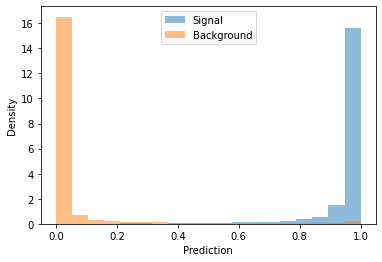

In [24]:
bins = np.linspace(0, 1, 20)

plt.hist(predict[sig][:,1].numpy(), bins, alpha=0.5, label='Signal', density=True)
plt.hist(predict[bkg][:,1].numpy(), bins, alpha=0.5, label='Background', density=True)
# plt.ylim(0,25000)
# plt.yscale('log')
plt.legend(loc='upper center')
plt.xlabel('Prediction')
plt.ylabel('Density')
plt.show()

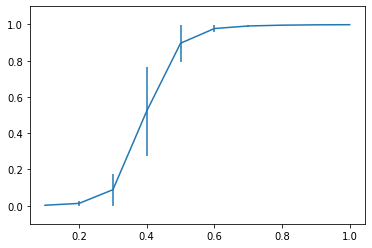

In [25]:
mean, bin_edges, binnumber = binned_statistic( x, predict[:,1], statistic='mean', bins=10)
std, bin_edges, binnumber = binned_statistic( x, predict[:,1], statistic='std', bins=10)

plt.errorbar(bin_edges[1:], mean, yerr=std)
plt.ylim([-0.1,1.1])
plt.savefig('classifier_x.png')
plt.show()

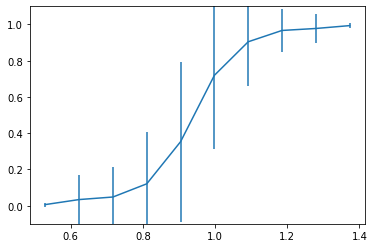

In [26]:
mean, bin_edges, binnumber = binned_statistic( z, predict[:,1], statistic='mean', bins=10)
std, bin_edges, binnumber = binned_statistic( z, predict[:,1], statistic='std', bins=10)

plt.errorbar(bin_edges[1:], mean, yerr=std)
plt.ylim(-0.1,1.1)
plt.savefig('classifier_z.png')
plt.show()

In [27]:
data = {
       'pred':predict[:,1].numpy(),
        'x':x,
       'z':z,
       } 

df1 = pd.DataFrame(data)
corr1 = df1.corr().round(2).style.background_gradient(cmap='Blues').format(precision=2)
corr1

,pred,x,z
pred,1.00,0.95,0.69
x,0.95,1.00,0.62
z,0.69,0.62,1.00


## Train Adversary

In [28]:
outputs = []
classifier_x_batch = []
for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    
    outputs.append(tf.nn.softmax(classifier(x_batch_train)))
    classifier_x_batch.append(x_batch_train)
    

In [29]:
epochs = 10
adversary_losses = []
adversary_ytrue = []
adversary_ypred = []

for epoch in range(epochs):

    

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset_adv):

        with tf.GradientTape() as tape:

            adversary_inputs = [tf.nn.softmax(classifier(classifier_x_batch[step], training=False)), x_batch_train]
            logits = adversary(adversary_inputs, training=True)  # Logits for this minibatch
            
            loss_value = advLoss(tf.cast(y_batch_train, dtype=float),
                                          tf.nn.softmax(logits))
            
            if (math.isnan(abs(loss_value.numpy()))):
                print("loss_value is nan")
                break
                
    
            # save the losses from the last epoch
            if (epoch > epochs - 2):
                adversary_losses.append(loss_value)
                adversary_ypred.append(tf.nn.softmax(adversary(adversary_inputs, training=False)))
                adversary_ytrue.append(y_batch_train)

    
    
        grads = tape.gradient(loss_value, adversary.trainable_weights)
        loss = grads

        optimizer_adv.apply_gradients(zip(grads, adversary.trainable_weights))
        
    if (math.isnan(abs(loss_value.numpy()))):
        break


    print('Epoch {0} loss = {1:0.4f}'.format(epoch, loss_value.numpy()))



Epoch 0 loss = 0.0461
Epoch 1 loss = 0.0433
Epoch 2 loss = 0.0034
Epoch 3 loss = 0.0016
Epoch 4 loss = 0.0010
Epoch 5 loss = 0.0007
Epoch 6 loss = 0.0005
Epoch 7 loss = 0.0004
Epoch 8 loss = 0.0003
Epoch 9 loss = 0.0003


## Train Classifier with $ \mathcal{L} = \mathcal{L_{class}} - \lambda \mathcal{L_{adv}} $

In [31]:
adversary = getAdversary('adversary')
# adversary.load_weights('adversary_weights.h5')

In [72]:
classifier = getClassifier('classifier')

In [73]:
adversary_ypred = []
adversary_ytrue = []
adversary_binned_x = []

for step, (x_batch_train, y_batch_train) in enumerate(train_dataset_adv):

    adversary_inputs = [outputs[step], x_batch_train]
    adversary_ypred.append(tf.nn.softmax(adversary(adversary_inputs, training=False)))
    adversary_ytrue.append(y_batch_train)
    adversary_binned_x.append(x_batch_train)

In [74]:
# plt.plot(np.arange(len(adversary_losses)), adversary_losses, marker='o', markersize=1)
# print(np.average(adversary_losses)*100)

In [75]:
# factor = np.round(np.abs(0.25/np.average(adversary_losses)), 1)
factor = HPARAMS.Lambda
factor = 300
factor

300

In [76]:
epochs = 2
loss = 0
logits = 0
preds = 0
loss_class = 0
loss_adv = 0
for epoch in range(epochs):
    
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        with tf.GradientTape() as tape:

            logits = classifier(x_batch_train, training=True)  # Logits for this minibatch
            
            preds = y_batch_train
            
            adversary_inputs = [tf.nn.softmax(logits), adversary_binned_x[step]]
            
            logits_adv = adversary(adversary_inputs, training=False)
            
            loss_class = classifierLoss(tf.cast(np.array([1-y_batch_train, y_batch_train]).T, dtype=float),
                                          tf.nn.softmax(logits))
            
            loss_adv = advLoss(tf.cast(adversary_ytrue[step], dtype=float), tf.nn.softmax(logits_adv))
            
#             print(loss_class.numpy())
#             print(loss_adv.numpy())
            
            # L = L_classifier + factor*L_adversary
            loss_value = loss_class - factor*loss_adv
            
            if(loss_value.numpy() < 0):
                loss_value = tf.abs(loss_value)

#             loss_adv = adversary_losses[step]

            

        grads = tape.gradient(loss_value, classifier.trainable_weights)
        loss = grads
        
        optimizer_class.apply_gradients(zip(grads, classifier.trainable_weights))
        
   

    print('Epoch {0} loss = {1:0.4f} loss_class = {2:0.4f} loss_adv = {3:0.4f}'.format(epoch,
                                                                                       loss_value.numpy(),
                                                                                       loss_class.numpy(),
                                                                                      loss_adv.numpy()))



Epoch 0 loss = 96.7796 loss_class = 0.5063 loss_adv = 0.3243
Epoch 1 loss = 96.7822 loss_class = 0.5226 loss_adv = 0.3243


In [77]:
logits = adversary([classifier(feats), bin_x])
predict = tf.nn.softmax(logits)

In [78]:
bin00 = np.average(predict.numpy()[bin_labels[:,0]==1], axis=0)[0]
bin01 = np.average(predict.numpy()[bin_labels[:,0]==1], axis=0)[1]
bin02 = np.average(predict.numpy()[bin_labels[:,0]==1], axis=0)[2]
bin03 = np.average(predict.numpy()[bin_labels[:,0]==1], axis=0)[3]

bin10 = np.average(predict.numpy()[bin_labels[:,1]==1], axis=0)[0]
bin11 = np.average(predict.numpy()[bin_labels[:,1]==1], axis=0)[1]
bin12 = np.average(predict.numpy()[bin_labels[:,1]==1], axis=0)[2]
bin13 = np.average(predict.numpy()[bin_labels[:,1]==1], axis=0)[3]

bin20 = np.average(predict.numpy()[bin_labels[:,2]==1], axis=0)[0]
bin21 = np.average(predict.numpy()[bin_labels[:,2]==1], axis=0)[1]
bin22 = np.average(predict.numpy()[bin_labels[:,2]==1], axis=0)[2]
bin23 = np.average(predict.numpy()[bin_labels[:,2]==1], axis=0)[3]

bin30 = np.average(predict.numpy()[bin_labels[:,3]==1], axis=0)[0]
bin31 = np.average(predict.numpy()[bin_labels[:,3]==1], axis=0)[1]
bin32 = np.average(predict.numpy()[bin_labels[:,3]==1], axis=0)[2]
bin33 = np.average(predict.numpy()[bin_labels[:,3]==1], axis=0)[3]


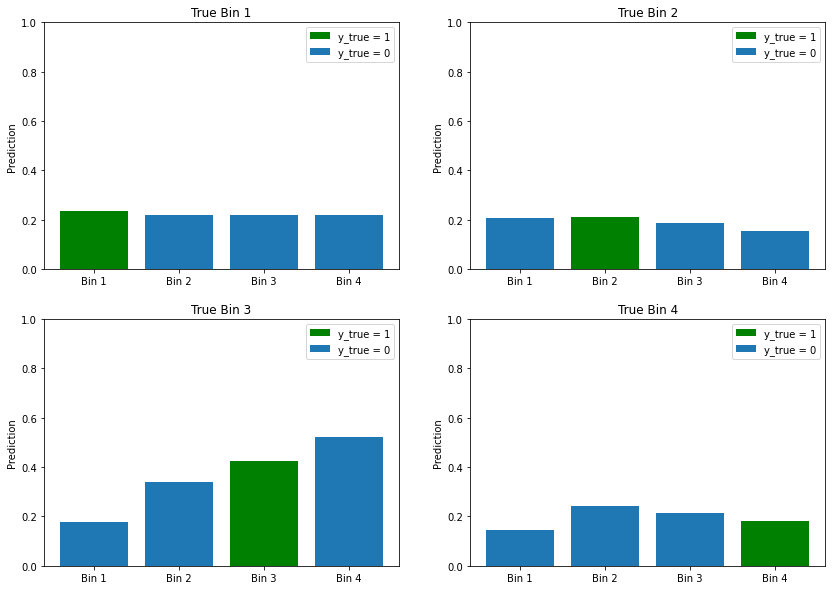

In [79]:
fig, axes = plt.subplots(2,2, figsize=(14,10))
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]

b1 = ax1.bar([0,1,2,3], [bin00, bin01, bin01, bin01])
b2 = ax2.bar([0,1,2,3], [bin10, bin11, bin21, bin31])
b3 = ax3.bar([0,1,2,3], [bin20, bin12, bin22, bin32])
b4 = ax4.bar([0,1,2,3], [bin30, bin13, bin23, bin33])


x1 = b1[0].get_xy()[0]
w1 = x1 + b1[0].get_width()
h1 = b1[0].get_height()

x2 = b2[1].get_xy()[0]
w2 = x2 + b2[1].get_width()
h2 = b2[1].get_height()

x3 = b3[2].get_xy()[0]
w3 = x3 + b3[2].get_width()
h3 = b3[2].get_height()

x4 = b4[3].get_xy()[0]
w4 = x4 + b4[3].get_width()
h4 = b4[3].get_height()

ax1.fill([x1, x1, w1, w1], [0, h1, h1, 0], "green")
ax2.fill([x2, x2, w2, w2], [0, h2, h2, 0], "green")
ax3.fill([x3, x3, w3, w3], [0, h3, h3, 0], "green")
ax4.fill([x4, x4, w4, w4], [0, h4, h4, 0], "green")

ax1.set_xticks([0,1,2,3])
ax2.set_xticks([0,1,2,3])
ax3.set_xticks([0,1,2,3])
ax4.set_xticks([0,1,2,3])

ax1.set_xticklabels(['Bin 1', 'Bin 2', 'Bin 3', 'Bin 4'])
ax2.set_xticklabels(['Bin 1', 'Bin 2', 'Bin 3', 'Bin 4'])
ax3.set_xticklabels(['Bin 1', 'Bin 2', 'Bin 3', 'Bin 4'])
ax4.set_xticklabels(['Bin 1', 'Bin 2', 'Bin 3', 'Bin 4'])

ax1.set_title('True Bin 1')
ax2.set_title('True Bin 2')
ax3.set_title('True Bin 3')
ax4.set_title('True Bin 4')


ax1.set_ylabel('Prediction')
ax2.set_ylabel('Prediction')
ax3.set_ylabel('Prediction')
ax4.set_ylabel('Prediction')


ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)
ax4.set_ylim(0, 1)

ax1.legend(['y_true = 1', 'y_true = 0'])
ax2.legend(['y_true = 1', 'y_true = 0'])
ax3.legend(['y_true = 1', 'y_true = 0'])
ax4.legend(['y_true = 1', 'y_true = 0'])

plt.show()

In [80]:
logits = classifier(feats)
predict = tf.nn.softmax(logits)
sig = y==1
bkg = y==0

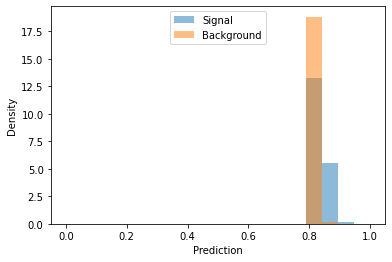

In [81]:
bins = np.linspace(0, 1, 20)

plt.hist(predict[sig][:,1].numpy(), bins, alpha=0.5, label='Signal', density=True)
plt.hist(predict[bkg][:,1].numpy(), bins, alpha=0.5, label='Background', density=True)
# plt.ylim(0,25000)
# plt.yscale('log')
plt.legend(loc='upper center')
plt.xlabel('Prediction')
plt.ylabel('Density')
plt.show()

min = 0.80  max = 0.91


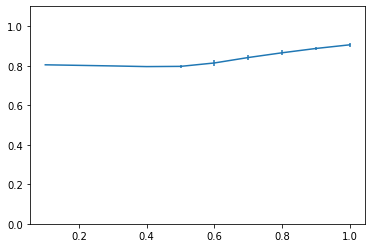

In [82]:
mean, bin_edges, binnumber = binned_statistic( x, predict[:,1], statistic='mean', bins=10)
std, bin_edges, binnumber = binned_statistic( x, predict[:,1], statistic='std', bins=10)

plt.errorbar(bin_edges[1:], mean, yerr=std)
plt.ylim([0,1.1])
plt.savefig('classifier_adversary_x.png')
print('min = {0:0.2f}  max = {1:0.2f}'.format(np.min(mean), np.max(mean)))
plt.show()

min = 0.80  max = 0.82


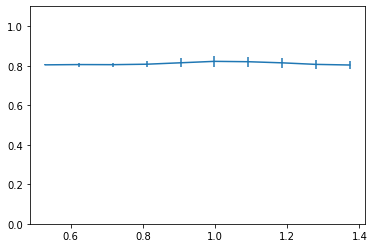

In [83]:
mean, bin_edges, binnumber = binned_statistic( z, predict[:,1], statistic='mean', bins=10)
std,  bin_edges, binnumber = binned_statistic( z, predict[:,1], statistic='std',  bins=10)

plt.errorbar(bin_edges[1:], mean, yerr=std)
plt.ylim(0,1.1)
plt.savefig('classifier_adversary_z.png')
print('min = {0:0.2f}  max = {1:0.2f}'.format(np.min(mean), np.max(mean)))
plt.show()

In [84]:
# mean, bin_edges, binnumber = binned_statistic( z, x, statistic='count', bins=10)
# plt.scatter(bin_edges[1:], mean)
# plt.show()

In [85]:
data = {
       'pred':predict[:,1].numpy(),
        'x':x,
       'z':z,

       }

In [86]:
df = pd.DataFrame(data)

In [87]:
corr = df.corr().round(2).style.background_gradient(cmap='Blues', axis=None).format(precision=2)
corr

,pred,x,z
pred,1.00,0.69,0.19
x,0.69,1.00,0.62
z,0.19,0.62,1.00


In [88]:
change = (df.corr() - df1.corr())
change[['x','z']].loc[['pred']].round(2)#.style.background_gradient(cmap='PRGn', axis=None)

,x,z
pred,-0.26,-0.5


In [89]:
printTime(time.time() - start)

Time 3m 11.09s


In [90]:
# 10 epochs for classifier only
# 10 epochs for adversary
# 100 epochs for classifier
#
# loss = 0.2792
# lambda = 1250
#
#
#       pred     x     z
# pred  1.00  0.46  0.91
# x     0.46  1.00  0.36
# z     0.91  0.36  1.00
#
#
# change: x = -0.48, z = +0.48
#
#
#
#
#
#
#

In [ ]:
adversary.layers

In [ ]:
for w in adversary.layers:
    print(w.name)
    print(w.get_weights())